In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print('This notebook is not stale yet!')

This notebook is not stale yet!


In [3]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 2 # goes from 1-8
D_full_1 = 19*u.mm
k_ll = 1/(D_full_1 * ca_80 / 100)

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for {} flats ({} total mirrors)'.format(D_full_1, ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/19mm_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
    print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
    print('var at n{}: {:.3f}'.format(ntest+1, ap_var))

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)
    print('delta k at n{}: {:.5f}'.format(ntest+1, delta_k))

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test n{}: {:.3f}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
    print('cal var test n{}: {:.3f}'.format(ntest+1, np.sum(cal_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    #(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_ll.value)
    print('norm PSD units n{}: {}'.format(ntest+1, mv_n.unit)) # should be mm2
    print('cal PSD units n{}: {}'.format(ntest+1, mv_c.unit))  # should be mm2 nm2

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mn_psd_1 = np.zeros((ntot_1, np.shape(mv_n)[0]))
        mc_psd_1 = np.zeros((ntot_1, np.shape(mv_c)[0]))

    kval_1[ntest,:] = copy.copy(kval)
    mn_psd_1[ntest,:] = copy.copy(mv_n)
    mc_psd_1[ntest,:] = copy.copy(mv_c)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)
    surf_pwr_1[ntest,:,:] = copy.copy(pwr_opt)

# force in the units, they will be the same across each iteration
kval_1 *= kval.unit
mn_psd_1 *= mv_n.unit
mc_psd_1 *= mv_c.unit
var_1 *= ap_var.unit
surf_pwr_1 *= pwr_opt.unit

print('All PSD measurement tests done, begin calculating average PSDs (normalized and calibrated)')

# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1 and mc_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
    
# Step 3.5: Take average of collection of data calibrated PSDs
avg_psd_data = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_data[i] = np.sum(mc_psd_1[:,i].value)/np.shape(mc_psd_1)[0]
avg_psd_data *= mc_psd_1.unit

# step 4: scale the average norm PSD by average variance data from Step 1
avg_psd_norm = avg_psd * mn_psd_1.unit * avg_tot_var
# no need on the average data calibrated one because it is already set with the correct units.

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Crunching individual PSDs for 19.0 mm flats (2 total mirrors)
surf unit at n1: mm
var at n1: 2.108 nm2
delta k at n1: 0.00270 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 2.108 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
surf unit at n2: mm
var at n2: 2.309 nm2
delta k at n2: 0.00270 1 / mm
PSD normalized: var=1.000
var test n2: 1.000
cal var test n2: 2.309 nm2
norm PSD units n2: mm2
cal PSD units n2: mm2 nm2
Finished calculating PSD for surface 2
All PSD measurement tests done, begin calculating average PSDs (normalized and calibrated)
Finished calculating average PSDs (normalized and calibrated)


In [4]:
# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1 and mc_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
    
# Step 3.5: Take average of collection of data calibrated PSDs
avg_psd_data = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_data[i] = np.sum(mc_psd_1[:,i].value)/np.shape(mc_psd_1)[0]
avg_psd_data *= mc_psd_1.unit

# step 4: scale the average norm PSD by average variance data from Step 1
avg_psd_norm = avg_psd * mn_psd_1.unit * avg_tot_var
# no need on the average data calibrated one because it is already set with the correct units.

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Finished calculating average PSDs (normalized and calibrated)


In [8]:
1/((ca_80/100)*D_full_1) # absolute lowest spatial frequency

<Quantity 0.06578947 1 / mm>

In [9]:
np.amin(kval_1) # must be above lowest spatial frequency

<Quantity 0.06745991 1 / mm>

In [10]:
np.amax(FT_freq) # max spatial frequency

<Quantity 5.52361739 1 / mm>

In [11]:
np.amax(kval_1) # must be below max spatial frequency

<Quantity 5.5182206 1 / mm>

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

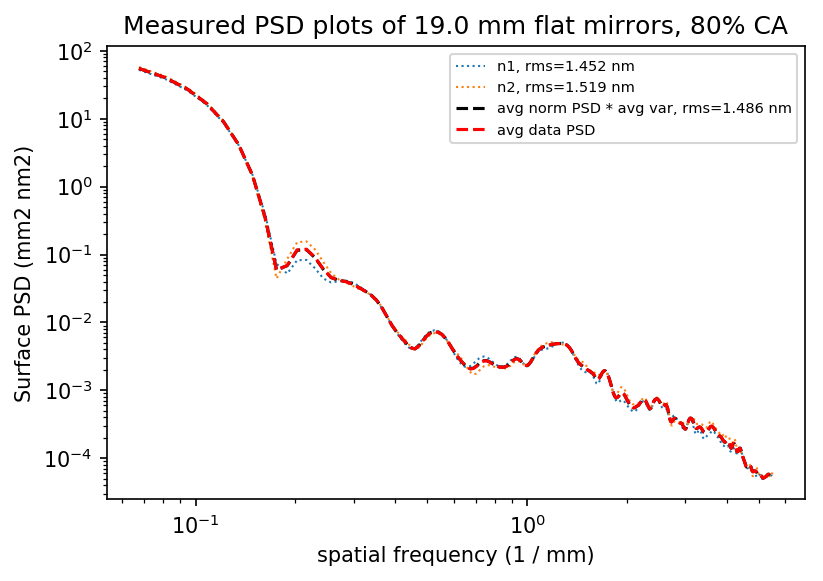

In [7]:
rms_1 = np.sqrt(var_1)
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], ':', label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_psd_norm, 'k--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0,:], avg_psd_data, 'r--', label='avg data PSD')
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

## Build the PSD plots
Solving for alpha, beta, l0, and L0

In [12]:
def calc_beta(alpha, var, D_clear, npix_diam):
    kmin = 1 / D_clear
    kmax = 1/ (2 * D_clear / npix_diam)
    
    if alpha == 2:
        beta = var / ( 2* np.pi * np.log(kmax/kmin) )
    else: # when beta is not 2
        beta = var * (alpha - 2) / (2 * np.pi * ( (kmin**(2 - alpha)) - (kmax**(2 - alpha)) ) )
    
    return beta

In [13]:
alpha = 2 # set for flats
alpha_fit = 1/(kval_1[0][:]**alpha)

beta = calc_beta(alpha, avg_tot_var, D_full_1*ca_80/100, np.mean(npix_diam_1))
beta

<Quantity 0.07932502 nm2>

In [31]:
beta = np.zeros((ntot_1))
for ns in range(0,ntot_1):
    kmin = 1/(D_full_1.value*ca_val/100)
    kmax = 1/(2*D_full_1.value*(ca_val/100)/npix_diam_1[ns])
    beta[ns] = var_1[ns] / (2*np.pi * np.log(kmax/kmin) )
beta

array([3.16023293e-13, 3.03783599e-13, 3.81038900e-13, 2.25331885e-13,
       2.31614823e-13, 3.32070514e-13, 1.56813358e-13, 2.92517134e-13])

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

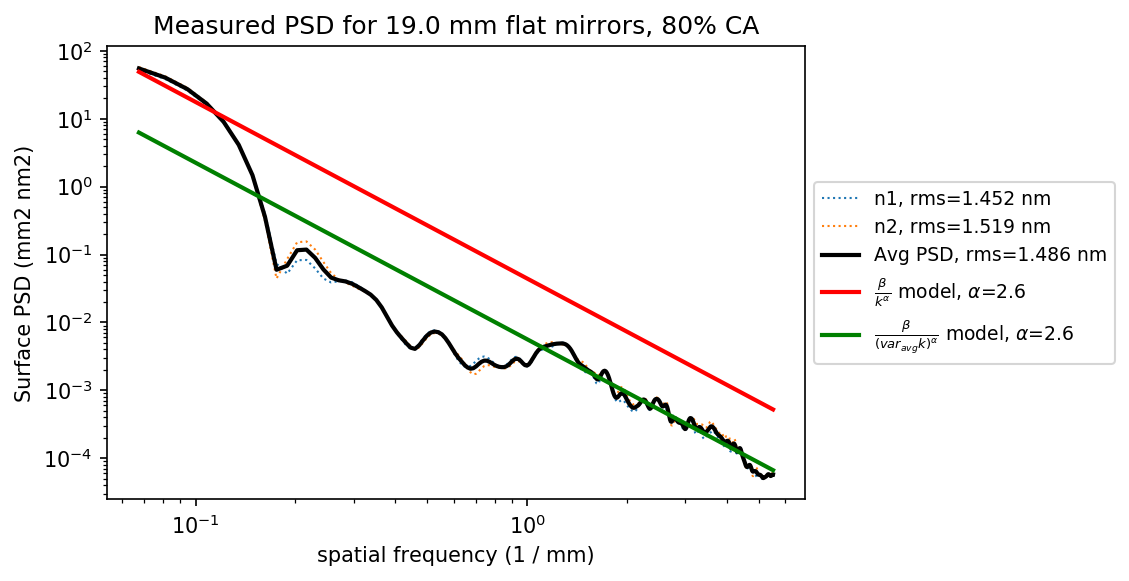

In [23]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(kval_1[0].value)
k_size = np.shape(kval_1[0])[0]
kfit = np.zeros((k_size))
for kn in range(0,k_size):
    kfit[kn] = np.abs(kval_1[0,kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = kval_1[0,klim_ind:k_size]

a2 = 2.6# estimate for OAP
b2 = calc_beta(a2, avg_tot_var, D_full_1*ca_80/100, np.mean(npix_diam_1))
a2_fit = b2/((k_range**a2))
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], ':', label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1.0)
plt.loglog(kval_1[0,:], avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)), linewidth=2.0)
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
plt.loglog(k_range, a2_fit1, 'g', label='{} model, {}={}'.format(r'$\frac{\beta}{(var_{avg}k)^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
plt.title('Measured PSD for {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 